# Importing and loading data

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

df = pd.read_csv('20200124_ews_observations.csv', low_memory=False)
df = df.dropna()
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'])

**Function that deletes the unnecessary columns so that only columns with numbers are kept and the datetime**

In [2]:
def remove_scores(df):
    df = df.drop(['SBP_Score', 'SpO2_Score', 'HR_Score', 'TEMP_Score', 'RR_Score', 'EwsProcedure', 'Add_O2', 'LOC'], axis=1)
    return df

**Function that returns a dataframe of the patient and some info about the measurements**

In [3]:
def analyse_patient (df, id_nr, plot=False):
    # only select rows from the patient
    patient = df.loc[df['PatientId'] == id_nr]
    patient = patient.sort_values(by='ObservationDate', ascending=True)
    # datetime as index
    patient = patient.set_index('ObservationDate')
    # drop NAN values and check how many samples are useful
    patient = patient.dropna()
    n_measurements = patient.shape[0]
    print(f"Number of measurements: {n_measurements}")
    
    patient = patient.drop(['EwsProcedure'], axis=1)
    
    # print the info
    if n_measurements > 1:
        # print average minimum and maximum time between measurements
        delta_t = patient.index.to_series().diff().dt.seconds.div(3600, fill_value=0)
        delta_t_avg = delta_t.mean()
        delta_t_max = delta_t.max()
        delta_t_min = delta_t.nsmallest(2).iloc[1]
        print(f"Average time (hours) between measurements of patient {id_nr}: {delta_t_avg}")
        print(f"Max diff time between measurements: {delta_t_max}")
        print(f"Min diff time between measurements: {delta_t_min}")
        
        # print start and end date of hospitalisation
        start_date = patient.index.values[0]
        end_date = patient.index.values[-1]
        print(f"Start_date: {start_date}")
        print(f"End_date: {end_date}")
        
        # check how many data we have on the patient
        delta_t = end_date - start_date
        delta_days = delta_t.astype('timedelta64[D]').astype('str')
        # delta_days prints "xx days"
        # next line cuts " days" out of the string delta_days
        delta_days = delta_days[:len(delta_days) - 5]
        print(f"Hospitalisation duration: {delta_days}")
        
    else:
        print("Only 1 measurement")
    
    
    
    if int(delta_days) >= 2 and n_measurements >= 15:
        to_predict = True
        print("This patient has enough data to apply an accurate model")
    else:
        to_predict = False
        print("Not enough data yet to predict EWS")
    
    # plot timeseries
    if plot:
        fig, ax = plt.subplots(figsize=(15,15))
        sns.lineplot(data=patient, x="ObservationDate", y='EWS_Total', linestyle='-', color='grey', ax=ax)
        sns.scatterplot(data=patient, x="ObservationDate", y='EWS_Total', marker='o', linestyle='-', hue="Add_O2_Score", palette="tab10", ax=ax)
    
    return patient, delta_days, to_predict

In [4]:
patientx = analyse_patient(df, 1092)
patientx[0].head()

Number of measurements: 272
Average time (hours) between measurements of patient 1092: 6.416708537581695
Max diff time between measurements: 23.004444444444445
Min diff time between measurements: 0.007222222222222222
Start_date: 2019-06-03T15:04:00.000000000
End_date: 2019-12-09T08:24:41.000000000
Hospitalisation duration: 188
This patient has enough data to apply an accurate model


,PatientId,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
ObservationDate,,,,,,,,,,,,,,,,
2019-06-03 15:04:00,1092,2,160.0,0.0,ALERT,0,92.0,0.0,True,2.0,73,0,18,0,36.4,0
2019-06-03 20:11:31,1092,2,152.0,0.0,ALERT,0,90.0,0.0,True,2.0,74,0,18,0,37.0,0
2019-06-04 07:07:14,1092,5,176.0,0.0,ALERT,0,96.0,2.0,True,2.0,72,0,18,0,36.0,1
2019-06-04 16:47:11,1092,2,167.0,0.0,ALERT,0,92.0,0.0,True,2.0,70,0,18,0,36.5,0
2019-06-05 07:23:21,1092,4,176.0,0.0,ALERT,0,96.0,2.0,True,2.0,70,0,19,0,36.3,0


**Function that returns a dictionary of the d values of the metrics**

In [5]:
def n_diffs(df_patient):
    from pmdarima.arima.utils import ndiffs
    n_diffs_dict  = {}
    metrics = ['SBP', 'SpO2', 'HR', 'RR', 'TEMP']
    for column in metrics:
        y = df_patient[column]
        n_diffs = ndiffs(y, test='adf')
        n_diffs_dict[column] = n_diffs
    return n_diffs_dict

**Function that returns a dictionary of the parameters of the models for each of the metrics**

In [6]:
def get_best_pdq(df_patient):
    from pmdarima.arima import auto_arima
    metric_pdq_dict = {}
    dict_ndiffs = n_diffs(df_patient)
    for metric in dict_ndiffs:
        ndiffs = dict_ndiffs[metric]
        best_pdq = auto_arima(df_patient[metric], d=ndiffs, trace=False)
        metric_pdq_dict[metric] = best_pdq.order
    return metric_pdq_dict

In [7]:
# from sklearn.metrics import mean_squared_error
# def pdq(df_patient):
#     from pmdarima.arima import auto_arima
#     metric_pdq_dict = {}
#     dict_ndiffs = n_diffs(df_patient)
#     for metric in dict_ndiffs:
#         X = df_patient[metric]
#         print(X)
#         size = int(len(X) * 0.66)
#         train, test = X[0:size], X[size:len(X)]
#         ndiffs = dict_ndiffs[metric]
#         model = auto_arima(train, d=ndiffs, trace=False)
#         preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)
#         print(f"Test RMSE {metric}: {np.sqrt(mean_squared_error(test, preds))}" )
#     return metric_pdq_dict
# pdq(patientx)

**Function that models and fits an ARIMA model for each of the metrics and also plots things**

In [16]:
# def model_and_predict(df_patient):
#     from pmdarima.arima import ARIMA
#     from sklearn.model_selection import TimeSeriesSplit
#     from math import sqrt
#     from sklearn.metrics import mean_squared_error
    
#     metrics = ['SBP', 'SpO2', 'HR', 'RR', 'TEMP']
#     pdq_dict = get_best_pdq(df_patient)
#     print(pdq_dict)
#     for metric in metrics:
#         X = df_patient[metric].values
#         size = int(len(X) * 0.66)
#         train, test = X[0:size], X[size:len(X)]
#         history = [x for x in train]
#         predictions = []
#         df_patient[metric]
#         print(f"-----------------------------{metric}--------------------------------")
#         for t in range(len(test)): 
#             model = ARIMA(order=(pdq_dict[metric]))
#             output = model.fit_predict(history, n_periods=5)
#             yhat = output[0]
#             predictions.append(yhat)
#             obs = test[t]
#             history.append(obs)
#             #print('predicted=%f, expected=%f' % (yhat, obs))
#         # evaluate forecasts
#         rmse = sqrt(mean_squared_error(test, predictions))
#         print('Test RMSE: %.3f' % rmse)
#         # plot forecasts against actual outcomes
#         plt.plot(test)
#         plt.plot(predictions, color='red')
#         plt.show()
        

In [28]:
def model_and_predict(df_patient, days):
    from pmdarima.arima import ARIMA
    from sklearn.model_selection import TimeSeriesSplit
    from math import sqrt, floor
    from sklearn.metrics import mean_squared_error
    
    
    
    metrics = ['SBP', 'SpO2', 'HR', 'RR', 'TEMP']
    pdq_dict = get_best_pdq(df_patient)
    print(pdq_dict)
    for metric in metrics:
        print(f"-----------------------------{metric}--------------------------------")
        splits = floor(int(days)/(max(pdq_dict[metric])+1))
        print(splits)
        X = df_patient[metric]
        tss = TimeSeriesSplit(n_splits = splits)
        for train, test in tss.split(X):
            i = 1
            #print(f"{train} | {test}")
            model = ARIMA(order=(pdq_dict[metric]))
            predictions = model.fit_predict(train, n_periods = len(test))
            rmse = sqrt(mean_squared_error(test, predictions))
            print(f'Test RMSE {i}: {rmse}')
            i += 1

        plt.plot(test)
        plt.plot(predictions, color='red')
        plt.show()

nsplits=floor(amount of days/(max(pdq)+1)) -> floor so you have more datapoints per split

{'SBP': (0, 1, 2), 'SpO2': (1, 0, 1), 'HR': (2, 1, 3), 'RR': (1, 0, 0), 'TEMP': (0, 1, 2)}
-----------------------------SBP--------------------------------
62
Test RMSE 1: 1.2609992003488125e-05
Test RMSE 1: 1.2764479689556819e-05
Test RMSE 1: 1.3699815499927151e-05
Test RMSE 1: 1.3683927837503049e-05
Test RMSE 1: 1.3382853578852421e-05
Test RMSE 1: 1.385119567515212e-05
Test RMSE 1: 1.4859838830140402e-05
Test RMSE 1: 1.5200070625917773e-05
Test RMSE 1: 1.4937929624985035e-05
Test RMSE 1: 1.4479136020911248e-05
Test RMSE 1: 1.2264722755403938e-05
Test RMSE 1: 1.4368269902477521e-05
Test RMSE 1: 1.3915801120173471e-05
Test RMSE 1: 1.351695219641154e-05
Test RMSE 1: 1.3173342315765165e-05
Test RMSE 1: 1.2875674817435532e-05
Test RMSE 1: 1.26181170175816e-05
Test RMSE 1: 1.23945345008878e-05
Test RMSE 1: 1.219964383364853e-05
Test RMSE 1: 1.2029010111932374e-05
Test RMSE 1: 1.1875443307820222e-05
Test RMSE 1: 1.174327320764867e-05
Test RMSE 1: 1.1717937882475382e-05
Test RMSE 1: 1.152056

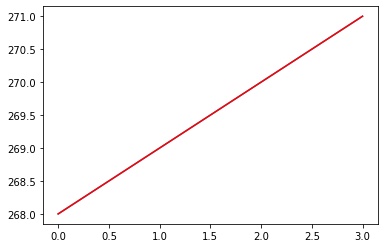

-----------------------------SpO2--------------------------------
94
Test RMSE 1: 1.1782084675203401
Test RMSE 1: 1.1901654668838455
Test RMSE 1: 1.1807905482994483
Test RMSE 1: 1.1743341663080133
Test RMSE 1: 1.2412756250785482
Test RMSE 1: 1.1842772264330825
Test RMSE 1: 1.1875935725674998
Test RMSE 1: 1.180312955312305
Test RMSE 1: 1.1815824111776085
Test RMSE 1: 1.1943813172531272
Test RMSE 1: 1.2255568746648864
Test RMSE 1: 1.196895875804834
Test RMSE 1: 1.202833744981798
Test RMSE 1: 1.2015193275769573
Test RMSE 1: 1.2221813253521472
Test RMSE 1: 1.2046504201188908
Test RMSE 1: 1.2152971412758051
Test RMSE 1: 1.2165517316202392
Test RMSE 1: 1.2135017304003965
Test RMSE 1: 1.2697981903149442
Test RMSE 1: 1.3118450957424737
Test RMSE 1: 1.2831706189152339
Test RMSE 1: 1.2301229844265333
Test RMSE 1: 1.2471203195928997
Test RMSE 1: 1.2216131876430323
Test RMSE 1: 1.2085226575438075
Test RMSE 1: 1.2316927516916245
Test RMSE 1: 1.2337002543129083
Test RMSE 1: 1.2340854478111105
Test R

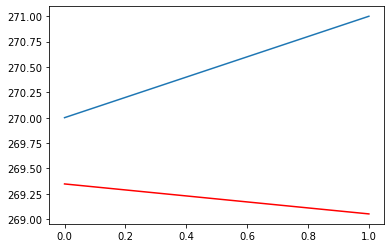

-----------------------------HR--------------------------------
47
Test RMSE 1: 2.2237591217438468e-05
Test RMSE 1: 2.5207223008756177e-05


LinAlgError: Schur decomposition solver error.

In [29]:
import warnings
warnings.filterwarnings('ignore')

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

model_and_predict(patientx[0], patientx[1])

**Functions that converts scores to EWS Total score**  
Two scales for SpO2

In [ ]:
def calculate_news2_scale1 (rr, spo2, air_score, sbp, hr, loc_score, temp, check=False):
    score = 0
    # RR SCORE - normal values: 12-20
    if rr <= 8 or rr >= 25:
        rr_score = 3
    elif 21 <= rr <= 24:
        rr_score = 2
    elif 9 <= rr <= 11:
        rr_score = 1
    else:
        rr_score = 0
    
    # SPO2 SCORE - normal values: >= 96
    if spo2 <= 91:
        spo2_score = 3
    elif 92 <= spo2 <= 93:
        spo2_score = 2
    elif 94 <= spo2 <= 95:
        spo2_score = 1
    else:
        spo2_score = 0
    
    # OXYGEN METHOD SCORE 
    # 0 -> Room Air 
    # 3 -> Oxygen Mask
    try:
        assert air_score == 0 or air_score == 2, "Air_score is not 0 or 2"
    except AssertionError:
        raise
    
    # SBP SCORE - normal values: 111-219
    if sbp <= 90 or sbp >= 220:
        sbp_score = 3
    elif 91 <= sbp <= 100:
        sbp_score = 2
    elif 101 <= sbp <= 110:
        sbp_score = 1
    else:
        sbp_score = 0
    
    # HR SCORE - normal values: 51-90
    if hr <= 40 or hr >= 131:
        hr_score = 3
    elif 111 <= hr <= 130:
        hr_score = 2
    elif 91 <= hr <= 110 or 41 <= hr <= 50:
        hr_score = 1
    else:
        hr_score = 0
    
    # CONSCIOUSNESS METHOD SCORE 
    # 0 -> Alert 
    # 3 -> CVPU (Confusion, Voice, Pain, Unresponsive)
    try:
        assert loc_score == 0 or loc_score == 3, "loc_score is not 0 or 3"
    except AssertionError:
        raise
    
    # TEMP SCORE - normal values: 51-90
    if temp <= 35.0:
        temp_score = 3
    elif temp > 39.1:
        temp_score = 2
    elif 35.1 <= temp <= 36.0 or 38.1 <= temp <= 39.0:
        temp_score = 1
    else:
        temp_score = 0
    
    if check:
        print(f'rr_score: {rr_score}')
        print(f'spo2_score: {spo2_score}')
        print(f'air_score: {air_score}')
        print(f'sbp_score: {sbp_score}')
        print(f'hr_score: {hr_score}')
        print(f'loc_score: {loc_score}')
        print(f'temp_score: {temp_score}')
    
    ews_total = rr_score + spo2_score + air_score + sbp_score + hr_score + loc_score + temp_score
    
    return ews_total

In [ ]:
def calculate_news2_scale2 (rr, spo2, air_score, sbp, hr, loc_score, temp, check=False):
    score = 0
    # RR SCORE - normal values: 12-20
    if rr <= 8 or rr >= 25:
        rr_score = 3
    elif 21 <= rr <= 24:
        rr_score = 2
    elif 9 <= rr <= 11:
        rr_score = 1
    else:
        rr_score = 0
    
    # SPO2 SCORE - normal values: >= 96
    if spo2 <= 83 or spo2 >= 97:
        spo2_score = 3
    elif 84 <= spo2 <= 85 or 95 <= spo2 <= 96:
        spo2_score = 2
    elif 86 <= spo2 <= 87 or 93 <= spo2 <= 94:
        spo2_score = 1
    else:
        spo2_score = 0
    
    # OXYGEN METHOD SCORE 
    # 0 -> Room Air 
    # 3 -> Oxygen Mask
    try:
        assert air_score == 0 or air_score == 2, "Air_score is not 0 or 2"
    except AssertionError:
        raise
    
    # SBP SCORE - normal values: 111-219
    if sbp <= 90 or sbp >= 220:
        sbp_score = 3
    elif 91 <= sbp <= 100:
        sbp_score = 2
    elif 101 <= sbp <= 110:
        sbp_score = 1
    else:
        sbp_score = 0
    
    # HR SCORE - normal values: 51-90
    if hr <= 40 or hr >= 131:
        hr_score = 3
    elif 111 <= hr <= 130:
        hr_score = 2
    elif 91 <= hr <= 110 or 41 <= hr <= 50:
        hr_score = 1
    else:
        hr_score = 0
    
    # CONSCIOUSNESS METHOD SCORE 
    # 0 -> Alert 
    # 3 -> CVPU (Confusion, Voice, Pain, Unresponsive)
    try:
        assert loc_score == 0 or loc_score == 3, "loc_score is not 0 or 3"
    except AssertionError:
        raise
    
    # TEMP SCORE - normal values: 51-90
    if temp <= 35.0:
        temp_score = 3
    elif temp > 39.1:
        temp_score = 2
    elif 35.1 <= temp <= 36.0 or 38.1 <= temp <= 39.0:
        temp_score = 1
    else:
        temp_score = 0
    
    if check:
        print(f'rr_score: {rr_score}')
        print(f'spo2_score: {spo2_score}')
        print(f'air_score: {air_score}')
        print(f'sbp_score: {sbp_score}')
        print(f'hr_score: {hr_score}')
        print(f'loc_score: {loc_score}')
        print(f'temp_score: {temp_score}')
    
    ews_total = rr_score + spo2_score + air_score + sbp_score + hr_score + loc_score + temp_score
    
    return ews_total

In [ ]:
def check_hit_acc (df, samples, to_print=False):
# if there is a hit with either of the scales it will append true to this list
    check_row = []
    test_df = df.sample(n=samples)
    # check every row and apply calculate_news2_scale1
    for index, row in test_df.iterrows():
        ews_row_calc = calculate_news2_scale1(rr=row.RR, spo2=row.SpO2, air_score=row.Add_O2_Score, sbp=row.SBP, 
                                       hr=row.HR, loc_score=row.LOC_Score, temp=row.TEMP, check=to_print)
        if int(ews_row_calc) == int(row.EWS_Total):
            check_row.append(True)
            if to_print == True:
                print("-----")
        # if this isn't a hit, apply calculate_news2_scale2 
        else:
            ews_row_calc_2 = calculate_news2_scale2(rr=row.RR, spo2=row.SpO2, air_score=row.Add_O2_Score, sbp=row.SBP, 
                                       hr=row.HR, loc_score=row.LOC_Score, temp=row.TEMP, check=to_print)
            if ews_row_calc_2 == int(row.EWS_Total):
                check_row.append(True)
                if to_print == True:
                    print("-----")
            # if both of the calculate methods fail, false will be appended to the list
            else:
                check_row.append(False)
                if to_print == True:
                    print(f"{row.name}: false")
                    print(f"calculated: {ews_row_calc} != given: {row.EWS_Total}")
                    print("-----")
    # print the accuracy of this function
    hit_perc = (check_row.count(True)/len(check_row))*100
    print(f"Accuracy of function: {hit_perc}")

In [ ]:
hit_acc_50 = check_hit_acc(df, samples=5000)